In [1]:
%matplotlib inline

import torch
import random
import copy
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook
from bogus import atk
from IPython.display import Audio 
from scipy.integrate import romb

sns.set()

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [3]:
def test(model, test_loader, adv_func=None, adversarial=False, eps=0.5):
    """
    Test model

    Args:
    test_loader: a PyTorch dataloader to test on
    adv_func: a function that returns adversarial examples 
    """
    model.train(False)
    
    test_loss = 0
    correct = 0

    criterion = nn.CrossEntropyLoss()
    
    if adversarial:
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            data= adv_func(model, data, target, eps=eps, single=True)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            test_loss += criterion(output, target).item()
        
    else:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

In [4]:
def train_init(model, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train(True)
    criterion = nn.CrossEntropyLoss()
    for data, target in train_loader:
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    return model

In [33]:
batch = next(iter(test_loader))
img = batch[0][0]
label = batch[1][0]

In [5]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def logits_forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def mutate(x, chance, mean, std):
    if np.random.rand() > (1-chance): 
        x = np.random.normal(loc=mean, scale=std)
        return x
    return x

In [7]:
def update_weights(params, chance):
    std = params.detach().std()
    return params.detach().apply_(lambda x: mutate(x, chance, x, std))

In [8]:
def mutate_weights(model, chance):
    model.cpu()
    params = list(model.parameters())
    for param in params:
        if len(param.shape) == 1:
            param.data = update_weights(param, chance)
        elif len(param.shape) == 2:
            for inner_param in param:
                    inner_param.data = update_weights(inner_param, chance)
        else:
            for inner_param in param:
                for last_channel in inner_param:
                    last_channel.data = update_weights(last_channel, chance)
    model.cuda()

In [9]:
def crossover(model1, model2):
    
    mod1 = copy.deepcopy(model1)
    mod2 = copy.deepcopy(model2)
    
    model1_params = list(mod1.parameters())
    model2_params = list(mod2.parameters())
    
    for i, param in enumerate(model1_params):
        if len(param.shape) == 1:
            split = int(np.random.uniform(low=0, high=param.shape[0]))
            first_half = param.view(-1)[:split].data 
            second_half = model2_params[i].view(-1)[split:].data
            comb = torch.cat((first_half, second_half)).view_as(param)
            first_half = param.view(-1)[split:].data
            second_half = model2_params[i].view(-1)[:split].data
            comb2 = torch.cat((first_half, second_half)).view_as(param)
            param.data = comb
            model2_params[i].data = comb2
        
        elif len(param.shape) == 2:
             for j, inner_param in enumerate(param):
                split = int(np.random.uniform(low=0, high=inner_param.shape[0]))
                first_half = inner_param.view(-1)[:split].data 
                second_half = model2_params[i][j].view(-1)[split:].data
                comb = torch.cat((first_half, second_half)).view_as(inner_param)
                first_half = inner_param.view(-1)[split:].data
                second_half = model2_params[i][j].view(-1)[:split].data
                comb2 = torch.cat((first_half, second_half)).view_as(inner_param)
                inner_param.data = comb
                model2_params[i][j].data = comb2

        else:
            for j, inner_param in enumerate(param):
                for k, last_channel in enumerate(inner_param):
                    split = int(np.random.uniform(low=0, 
                                high=last_channel.shape[0] * last_channel.shape[1]))
                    first_half = last_channel.view(-1)[:split].data 
                    second_half = model2_params[i][j][k].view(-1)[split:].data
                    comb = torch.cat((first_half, second_half)).view_as(last_channel)
                    first_half = last_channel.view(-1)[split:].data
                    second_half = model2_params[i][j][k].view(-1)[:split].data
                    comb2 = torch.cat((first_half, second_half)).view_as(last_channel)
                    last_channel.data = comb
                    model2_params[i][j][k].data = comb2
                    
        return mod1, mod2

In [18]:
class GeneticWeightOptimizer:

    def __init__(self, population_sz, test_fn, test_loader, adv_func, RUN):
        
        self.test = test_fn
        self.testloader = test_loader
        self.population_sz = population_sz
        self.adv_func = adv_func
        self.run = RUN
        self.best_correct = 0
        self.best_params = None
        
        torch.manual_seed(1)
        
        self.population = [train_init(NNet().cuda()) for i in range(self.population_sz)]

        self.test_results = {} 
        self.generation = 0

    def step(self, generations=1, save=False, phone=False):

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar

            self.generation += 1
            self.children = []
            self.evaluate_nets()


            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]

            # elites always included in the next population

            for no, i in enumerate(elite):
                self.children.append(self.population[i])

            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 5
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224,  0.01913, 0.00286, 0.000506]

            while len(self.children) < self.population_sz:
                pop = range(len([i for i in range(self.population_sz)]))
                sel_k = random.sample(pop, k=5)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k] *
                                 np.array(self.test_results[self.generation]['clean_correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                picks = np.random.choice(tournament_size, size=2, p=probs, replace=False)
                parent1 = rank[picks[0]]
                parent2 = rank[picks[1]]
                bestmodel1 = self.population[parent1[0]]
                bestmodel2 = self.population[parent2[0]]
                child1, child2 = crossover(bestmodel1, bestmodel2)
                mutate_weights(child1, 0.02)
                mutate_weights(child2, 0.02)
                self.children.append(child1)
                self.children.append(child2)

            self.population = self.children
            
    def evaluate_nets(self):
        """evaluate the models."""

        losses = []
        corrects = []
        clean_corrects = []

        self.test_results[self.generation] = {}

        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader, adv_func=self.adv_func,
                                    adversarial=True, eps=0.2)
            _, clean_correct = self.test(net, self.testloader)
            
            if correct > self.best_correct:
                
                tqdm.write('Generation {}: max:{}'
                        .format(self.generation, correct))
                
                self.best_correct = correct
                self.best_params = copy.deepcopy(list(net.parameters()))

            corrects.append(correct)
            clean_corrects.append(clean_correct)

        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

In [11]:
atk_func = atk().fgsm

In [25]:
test2 = GeneticWeightOptimizer(30, test, test_loader, atk_func, RUN=1)

In [14]:
#test1.step(generations=10)

In [57]:
lrs = [0.001, 0.001, 0.0001, 0.0001, 0.00001]

In [ ]:
for j in tnrange(10):
    test2.step(generations=100)
    for net in test2.children:
        net = train_init(net, lr=lrs[j % 5])

test2.step(generations=1)
            
Audio(filename='../data/chinese-gong.mp3',autoplay=True) #yes. 

In [24]:
def adversarial_train2(model, train_loader, adv_func=atk_func, eps=0.2):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    model.train(True)
    model.double()
    criterion = F.cross_entropy
    
    for data, target in train_loader:
            data, target = data.cuda().double(), target.cuda()
            data2= adv_func(model, data, target, eps=eps)
            
            optimizer.zero_grad()
            
            output1 = model(data)
            output2 = model(data2)
            
            loss1 = criterion(output1, target)
            loss2 = criterion(output2, target)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
    
    return model

In [26]:
for j in tnrange(4):
    test2.step(generations=500)
    for net in test2.children:
        net = adversarial_train2(net, train_loader)
        net.float()
        
test2.step(generations=1)
            
Audio(filename='../data/chinese-gong.mp3',autoplay=True) #yes. 

Generation 1: max:2680
Generation 1: max:3542
Generation 1: max:3824
Generation 1: max:3980
Generation 1: max:4003
Generation 1: max:4186
Generation 1: max:4318
Generation 3: max:4333
Generation 3: max:4646
Generation 5: max:4664
Generation 5: max:4728
Generation 6: max:4741
Generation 7: max:4763
Generation 9: max:4817
Generation 13: max:4963
Generation 14: max:4972
Generation 19: max:5025
Generation 21: max:5054
Generation 29: max:5055
Generation 31: max:5088
Generation 31: max:5136
Generation 39: max:5216
Generation 40: max:5234
Generation 41: max:5259
Generation 43: max:5266
Generation 44: max:5275
Generation 63: max:5299
Generation 80: max:5330
Generation 116: max:5336
Generation 153: max:5401
Generation 166: max:5509
Generation 179: max:5510
Generation 183: max:5537
Generation 203: max:5567
Generation 229: max:5644
Generation 255: max:5678
Generation 255: max:5755
Generation 288: max:5787
Generation 316: max:5822
Generation 373: max:5829
Generation 401: max:5833
Generation 420: m

Generation 501: max:6666
Generation 565: max:6668
Generation 624: max:6682
Generation 631: max:6732


Generation 1001: max:7028
Generation 1001: max:7035
Generation 1050: max:7043
Generation 1326: max:7065


Generation 1501: max:7245



Generation 2001: max:7365



In [27]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], np.array(optimizer.test_results[i+1][dataset])/100)
        mean = np.mean(optimizer.test_results[i+1][dataset]) / 100
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    #ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications (%)' )
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

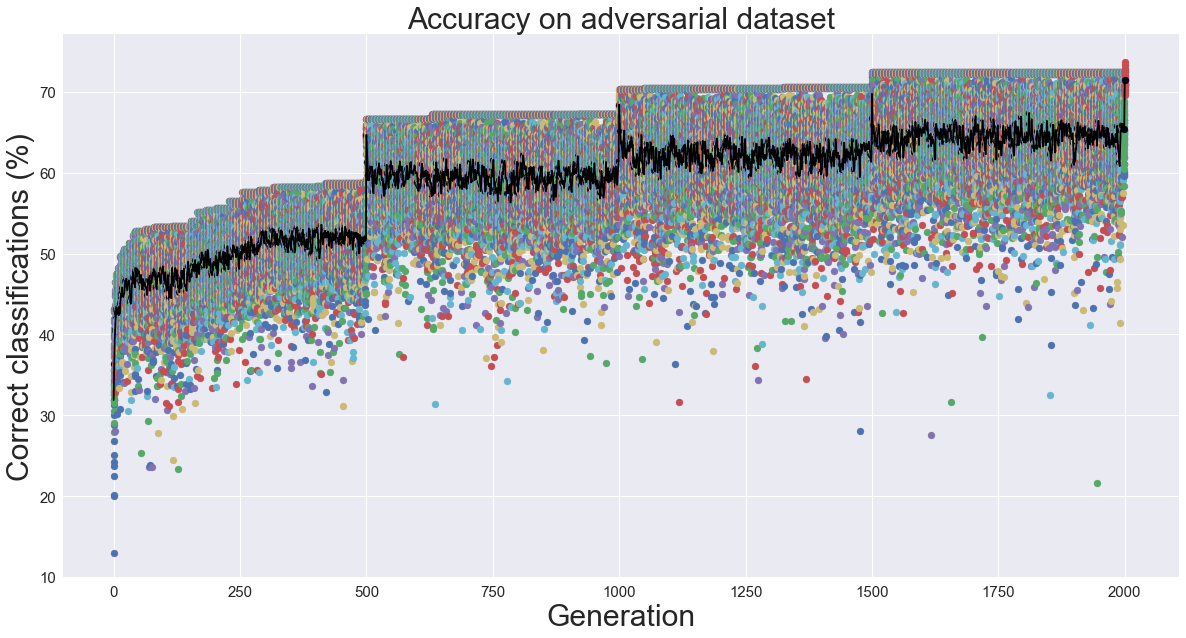

In [28]:
progressplotter(test2)

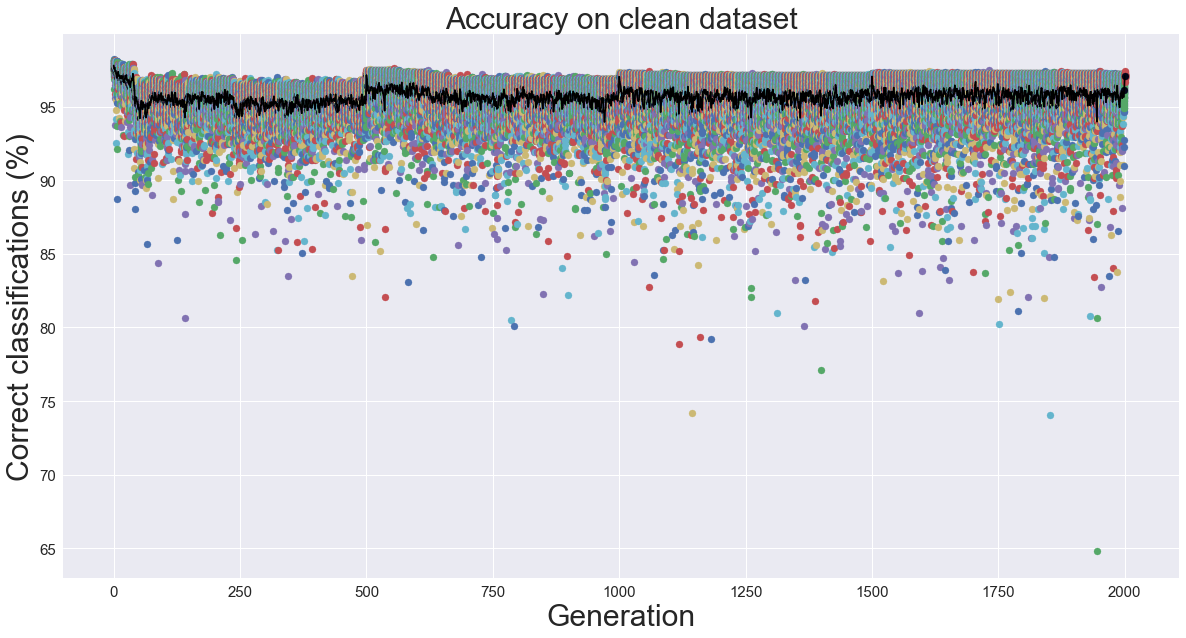

In [29]:
progressplotter(test2, clean=True)

In [30]:
best = NNet() 

In [31]:
for j, param in enumerate(best.parameters()):
    param.data = test2.best_params[j]

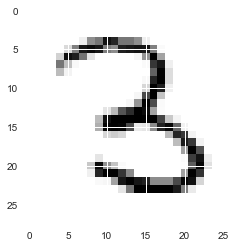

In [40]:
plt.imshow(img.cpu().numpy().reshape(28,28), cmap='Greys')

In [52]:
adver = atk_func(best, img.view(1,1,28,28), label.view(1), eps=0.2, single=True)

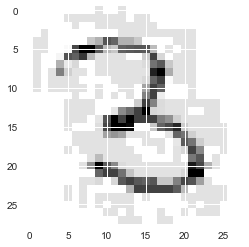

In [53]:
plt.imshow(adver.detach().cpu().numpy().reshape(28,28), cmap='Greys')

In [234]:
test(best, test_loader)

(7.141883373260498e-05, 9787)

In [235]:
test(best, test_loader, adv_func=atk_func, adversarial=True, eps=0.2)

(0.0007501166284084321, 7774)

In [82]:
eps_dict = {}

for i in range(101):
    _, eps_dict[i/100] = test(best, test_loader, adv_func=atk_func, adversarial=True, eps=i/100)

In [143]:
nums = np.linspace(start=0.0, stop=500, num=65) /1000

In [236]:
eps_dict = {}

for i in np.linspace(start=0.0, stop=500, num=65) /1000:
    _, eps_dict[i] = test(best, test_loader, adv_func=atk_func, adversarial=True, eps=float(i))

In [237]:
df4 =pd.DataFrame(eps_dict, index=[1]).T

In [238]:
df4.index.name = 'epsilon'
df4 = df4.reset_index()

In [239]:
df4.columns=['epsilon', 'accuracy'] 

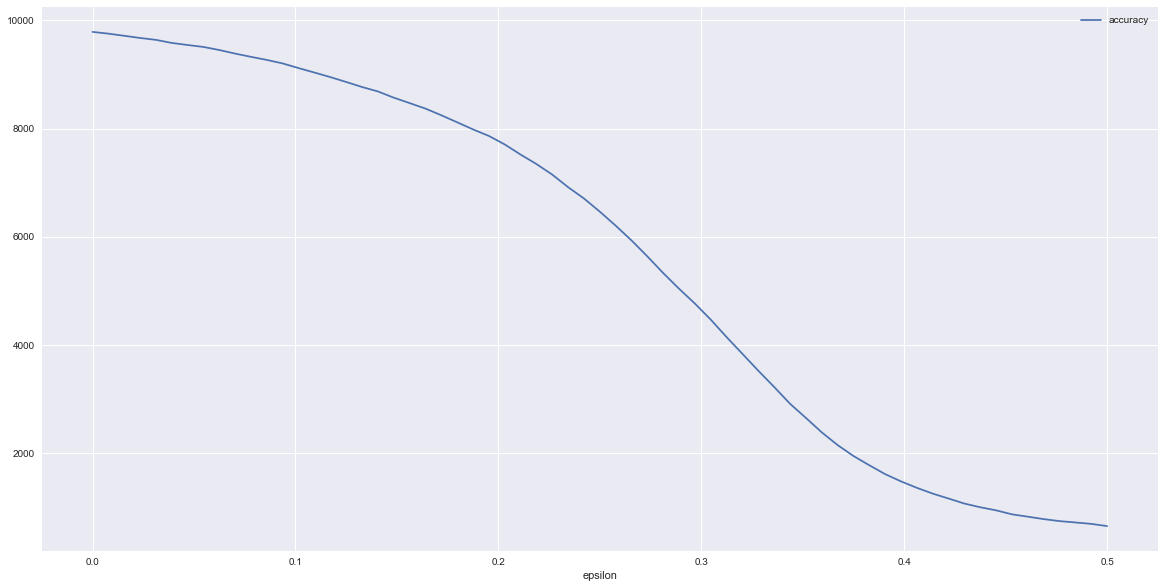

In [240]:
df4.plot(x='epsilon', figsize=(20,10))

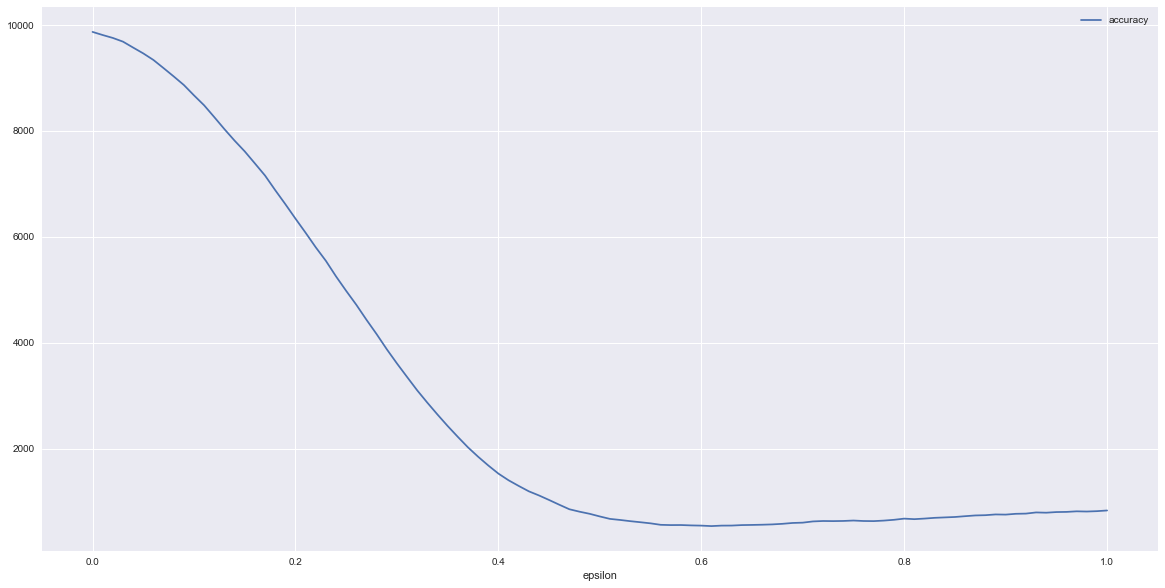

In [73]:
df.plot(x='epsilon', figsize=(20,10))

In [181]:
trial = NNet().cuda()

In [182]:
optimizer = torch.optim.Adam(trial.parameters(), lr=0.01)
trial.train(True)
criterion = nn.CrossEntropyLoss()
for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = trial(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [189]:
eps_dict2 = {}

for i in np.linspace(start=0.0, stop=500, num=65) /1000:
    _, eps_dict2[i] = test(trial, test_loader, adv_func=atk_func, adversarial=True, eps=float(i))

In [190]:
df2 = pd.DataFrame(eps_dict2, index=['Accuracy']).T
df2.index.name = 'epsilon'
df2 = df2.reset_index()

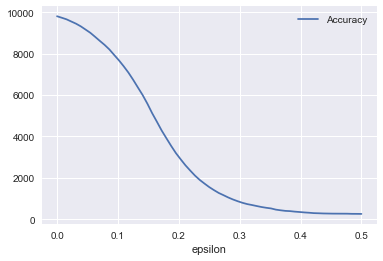

In [191]:
df2.plot(x='epsilon')

In [213]:
merged = df.join(df2, how='left',lsuffix='1')

In [214]:
merged = merged.drop('epsilon1', axis=1)
merged.columns = ['model1_accuracy', 'epsilon', 'model2_accuracy']

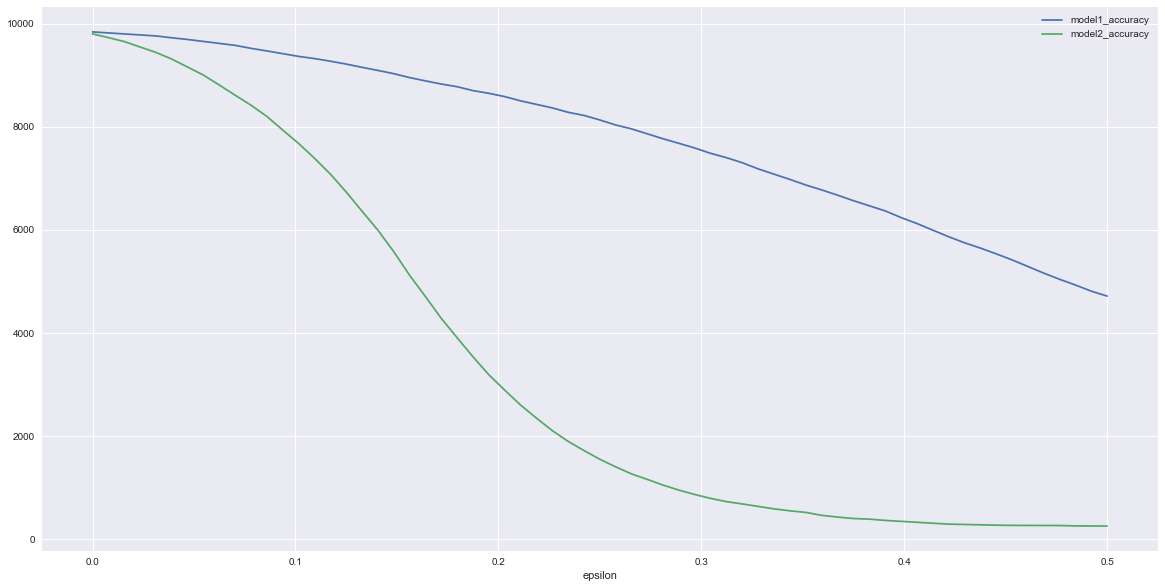

In [194]:
merged.plot(x='epsilon', figsize=(20,10))

In [195]:
optimizer = torch.optim.Adam(trial.parameters(), lr=0.01)

In [196]:
def adversarial_train(model, train_loader, adv_func=atk_func, eps=0.3, optimizer=optimizer):

    model.train(True)
    model.double()
    criterion = F.cross_entropy
    
    for data, target in train_loader:
            data, target = data.cuda().double(), target.cuda()
            data2= adv_func(model, data, target, eps=eps)
            
            optimizer.zero_grad()
            
            output1 = model(data)
            output2 = model(data2)
            
            loss1 = criterion(output1, target)
            loss2 = criterion(output2, target)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()

In [197]:
for i in range(4): adversarial_train(trial, train_loader)

In [198]:
trial.float()

NNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [137]:
test(trial, test_loader, adv_func=atk_func, adversarial=True, eps=0.2)

(0.00025545189678668974, 9245)

In [199]:
eps_dict3 = {}

for i in np.linspace(start=0.0, stop=500, num=65) /1000:
    _, eps_dict3[i] = test(trial, test_loader, adv_func=atk_func, adversarial=True, eps=float(i))

In [200]:
df3 = pd.DataFrame(eps_dict3, index=['Accuracy']).T
df3.index.name = 'epsilon'
df3 = df3.reset_index()

In [215]:
merged = merged.join(df3, lsuffix=2)

In [216]:
merged = merged.drop('epsilon2', axis=1)

In [217]:
merged.columns = list(merged.columns[:-1]) + ['model3_accuracy']

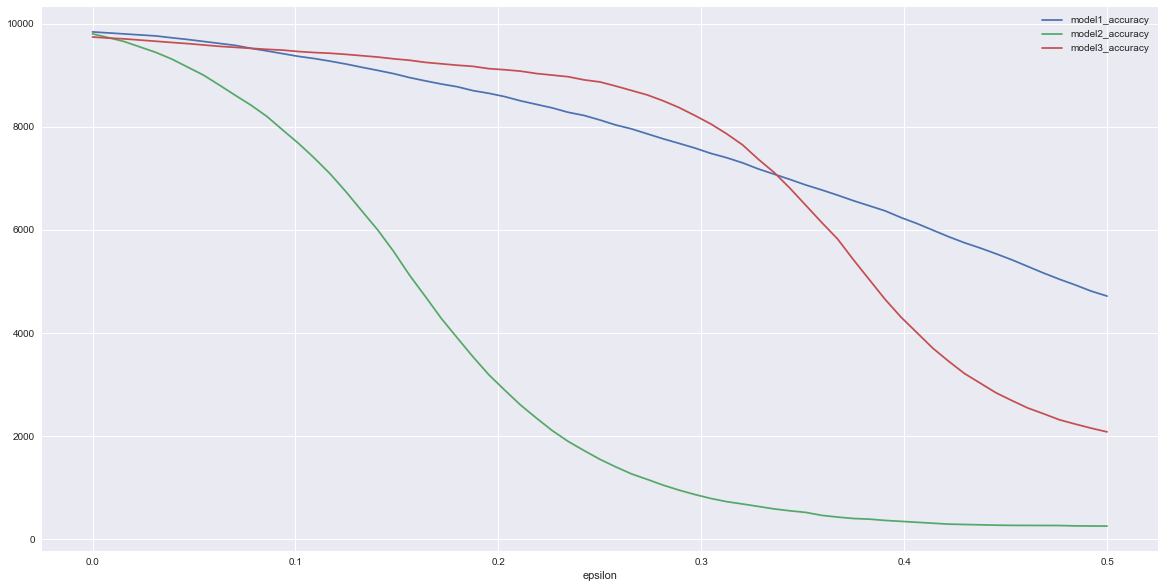

In [204]:
merged.plot(figsize=(20,10), x='epsilon')

In [219]:
romb(df['accuracy'].tolist(), dx=0.0078125)

2510.720093846146

In [220]:
romb(df2['Accuracy'].tolist(), dx=0.0078125)

1692.4472497404345

In [223]:
romb(df3['Accuracy'].tolist(), dx=0.0078125)

3701.43237612874

In [242]:
romb(df4['accuracy'].tolist(), dx=0.0078125)

2817.9418048485277

In [246]:
m2 =merged.join(df4, lsuffix=2)

In [249]:
m2.drop('epsilon2', axis=1, inplace=True)

In [251]:
m2.columns = list(m2.columns[:-1]) + ['model4_accuracy']

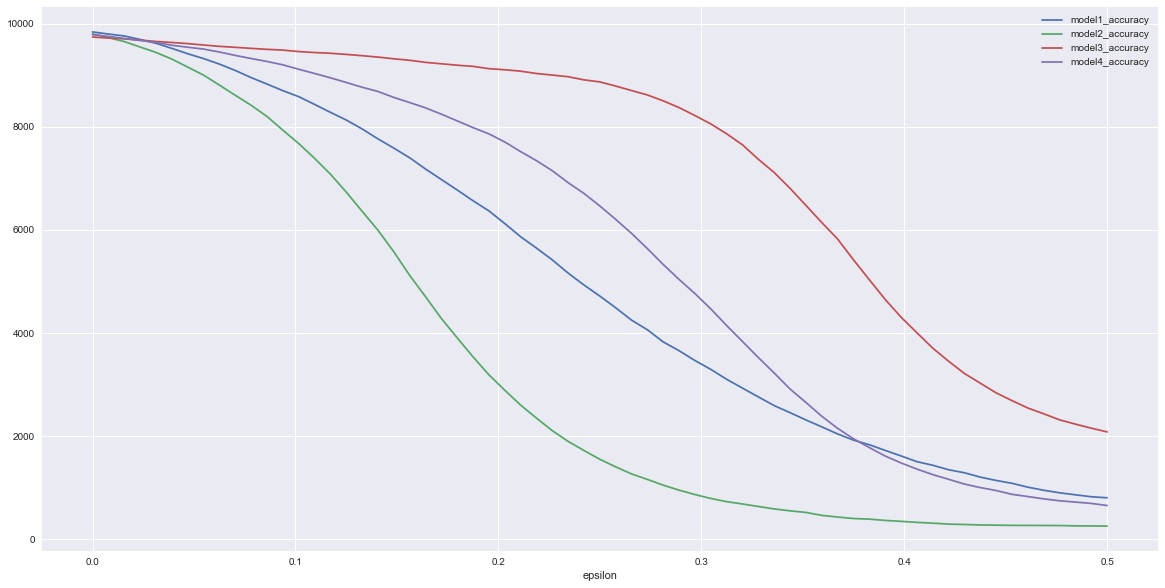

In [253]:
m2.plot(figsize=(20,10), x='epsilon')